In [1]:
# Q1_0130. 행렬 A가 직교행렬인지 확인

import numpy as np

A = np.array([[1, 2], [3, 4]])

# 행렬 A의 전치행렬
A_transpose = A.T

# 행렬 A와 그 전치행렬의 곱
A_dot = np.dot(A, A_transpose)

print(A_dot)

# 직교행렬의 정의에 따르면, 행렬과 그 전치행렬을 곱했을 때 결과가 단위행렬이 되어야 합니다. 
# 단위행렬은 대각선 원소만 1이고 나머지 원소가 모두 0인 행렬입니다. 하지만 위의 결과는 단위행렬이 아니므로, 행렬 
# A는 직교행렬이 아님을 알 수 있습니다

[[ 5 11]
 [11 25]]


In [2]:
# Q2_0130. 신용카드 데이터셋 전체 23개 속성에 대하여 6개의 컴포넌트를 가진 pca 변환을 수행하고 모델을 rf, cv=3, scoring='accuracy'을 적용하여 cross_val_score()로 분류 예측 수행하세요.

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# 엑셀 파일 로드
file_path = 'credit_card.xls'
df = pd.read_excel(file_path, sheet_name='Data', header=1)

# 칼럼 정리
df.rename(columns={'PAY_0': 'PAY_1', 'default payment next month': 'default'}, inplace=True)
y_target = df['default']
X_features = df.drop(['default', 'ID'], axis=1)

# 표준화 및 PCA 변환
scaler = StandardScaler()
X_features_scaled = scaler.fit_transform(X_features)
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_features_scaled)

# 랜덤 포레스트 분류기 생성 및 교차 검증
rf_clf = RandomForestClassifier(random_state=0)
scores = cross_val_score(rf_clf, X_pca, y_target, scoring='accuracy', cv=3)

print('PCA 변환된 데이터셋의 평균 정확도:', scores.mean())


PCA 변환된 데이터셋의 평균 정확도: 0.7954666666666667


## Online Retail Data set 기반으로 고객 세그멘테이션을 위한 군집분석을 다음 사항을 준수하여 수행하세요.

- 목표 :
  - 타깃 마케팅 : 고객을 여러 특성에 맞게 세분화해서 그 유형에 따라 맞춤형 마케팅이나 서비스를 제공.
  - 고객의 상품 구매 이력 데이터 기반에 기초한 타깃 마케팅

- 군집화 방법 :기본적인 고객 분석 요소인 RFM 기법을 이용해서 고객을 군집화 (RFM)

  - RECENCY(R): 가장 최근 상품 구입 일에서 오늘까지의 기간
  - FREQUENCY(F): 상품 구매 횟수
  - MONETARY VALUE(M) : 총 구매 금액

- 데이터셋
  - UCI 에서 제공하는 Online Retail Data set
  - 데이터셋 칼럼 구성
    - InvoiceNo: 주문번호, ‘C’로 시작하는 것은 취소 주문
    - StockCode: 제품 코드(Item Code)
    - Description: 제품 설명
    - Quantity : 주문 제품 건수
    - InvoiceDate: 주문 일자
    - UnitPrice: 제품 단가
    - CustomerID: 고객 번호
    - Country: 국가명(주문 고객의 국적)

- 분석 가이드

  - 1. 데이터 세트 로딩과 데이터 클렌징
    * Null 데이터 제거:  CustomerID의 Null 값이 많은 것으로 확인됨. 고객 세그멘이션을 수행하므로 고객 식별 번호가 없는 데이터는 삭제
    * 오류 데이터 삭제: 대표적인 오류 데이터는 Quantity 또는 UnitPrice 가 0보다 작은 경우. Quantity 가 0보다 작은 경우는 반환을 뜻하는 값으로 InvoiceNO 앞자리가 ‘C’로 되어있음. 분석의 효율성을 위해 삭제    
    * Country 칼럼의 주요 주문 고객 국가인 영국 데이터만을 필터링하여 선택 (위 과정을 거쳐서 df1 으로 새로 만들기)

  - 2. RFM 기반 데이터 가공
    * UnitPrice’(제품 단가), ‘Quantity’(주문 제품 건수)를 곱해서 '주문금액' 칼럼 생성, CusmtomerID int형으로 형변환
    * 주문 금액, 주문 횟수가 특정 고객에게 과도하게 되어있는지 탐색
      CustomerID로 group by 하여 TOP-5 구매 횟수 고객 ID 추출
      CustomerID로 group by 하고 주문 금액 칼럼을 더하여 TOP-5 주문 금액 고객 ID 추출

  - 3. 
    * 온라인 데이터 세트에 대해서 ‘InvocieNO(주문번호)’ + ‘StockCode(상품코드)’ 거의 1에 가까운 유일한 식별자 레벨로 되어있는지 확인
    * 주문번호 기준의 데이터를 개별 고객 기준의 데이터로 변환 - 고객 레벨로 주문 기간, 주문 횟수, 주문 금액 데이터를 기반으로 하여 세그멘테이션을 수행하기 위한 데이터 처리
    * 개별 고객 기준의 데이터 셋은 CustomerID, Recency, Frequency, Monetary 4개의 칼럼으로 구성  (df2 로 새로 만듬)
    
  - 4. RFM 기반 고객 세그멘테이션
    * 온라인 판매 데이터는 소매업체(b2b거래)로 추정되는 특정 고객의 대규모 주문이 포함되어 있어 주문 횟수와 주문 금액에서 개인 고객 주문과 매우 큰 차이가 있음을 왜곡된 데이터 분포도를 시각화하여 확인
    
    * 왜곡 정도가 매우 높은 데이터 세트에 K-평균을 적용하면 중심의 개수를 증가시키더라도 변별력이 떨어지는 군집화가 수행되기 때문에 StandScaler로 평균과 표준편차를 재조정한 후 시각화하여 군집화 결과를 확인. 시각화는 제공된 사용자 함수 이용하며 군집 개수를 2 ~ 5개 변화시키면서 수행
    
      - 제공된 코드로 아래 작업 수행
      - visualize_silhouette(cluster_lists, X_features)
      - visualize_kmeans_plot_multi(cluster_lists, X_features)    
    
   -5.  
    * 데이터 세트의 왜곡정도를 낮추기 위해 로그변환 이용하여 다시 시각화하여 군집화 결과를 확인
    
    * 3개 군집의 특징을 통계적 방법을 통해서 해석 및 활용 방안 수립

In [3]:
import pandas as pd

# Pandas를 이용해 엑셀 파일 읽기
df = pd.read_excel('Online_Retail.xlsx')

In [4]:
print(df.info())
print()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365   

In [5]:
# 각 열별로 Null 값이 있는지 확인
null_check = df.isnull().any()
print(null_check)

InvoiceNo      False
StockCode      False
Description     True
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID      True
Country        False
dtype: bool


In [6]:
#null 값이 몇개 인지 확인
null_count = df.isnull().sum()
print(null_count)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [7]:
# 1. 데이터 세트 로딩과 데이터 클렌징
# Null 데이터 제거: CustomerID의 Null 값이 많은 것으로 확인됨. 고객 세그멘테이션을 수행하므로 고객 식별 번호가 없는 데이터는 삭제
df = df[df['CustomerID'].notnull()]

# 오류 데이터 삭제: Quantity 또는 UnitPrice 가 0보다 작은 경우 삭제
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Country 칼럼의 주요 주문 고객 국가인 영국 데이터만을 필터링하여 선택
df = df[df['Country'] == 'United Kingdom']
df1 = df.copy()

print(df1.info())

<class 'pandas.core.frame.DataFrame'>
Index: 354321 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    354321 non-null  object        
 1   StockCode    354321 non-null  object        
 2   Description  354321 non-null  object        
 3   Quantity     354321 non-null  int64         
 4   InvoiceDate  354321 non-null  datetime64[ns]
 5   UnitPrice    354321 non-null  float64       
 6   CustomerID   354321 non-null  float64       
 7   Country      354321 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.3+ MB
None


In [8]:
# 2. RFM 기반 데이터 가공
# 'UnitPrice'와 ‘Quantity’를 곱해서 '주문금액' 칼럼 생성, CustomerID int형으로 형변환
df1['주문금액'] = df1['UnitPrice'] * df1['Quantity']    #OrderAmount
df1['CustomerID'] = df1['CustomerID'].astype(int)

# 주문 금액, 주문 횟수가 특정 고객에게 과도하게 되어있는지 탐색

# TOP-5 구매 횟수 고객 ID 추출
top_5_freq_customers = df1['CustomerID'].value_counts().head(5)

# TOP-5 주문 금액 고객 ID 추출
top_5_monetary_customers = df1.groupby('CustomerID')['주문금액'].sum().nlargest(5)

print('TOP-5 구매 횟수 고객:\n', top_5_freq_customers)
print()
print('TOP-5 구매 금액 고객:\n', top_5_monetary_customers)

TOP-5 구매 횟수 고객:
 CustomerID
17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: count, dtype: int64

TOP-5 구매 금액 고객:
 CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: 주문금액, dtype: float64


In [9]:
# 3. 
# * 온라인 데이터 세트에 대해서 ‘InvocieNO(주문번호)’ + ‘StockCode(상품코드)’ 거의 1에 가까운 유일한 식별자 레벨로 되어있는지 확인
# * 주문번호 기준의 데이터를 개별 고객 기준의 데이터로 변환 - 고객 레벨로 주문 기간, 주문 횟수, 주문 금액 데이터를 기반으로 하여 세그멘테이션을 수행하기 위한 데이터 처리
# * 개별 고객 기준의 데이터 셋은 CustomerID, Recency(가장최근구매로부터지난기간), Frequency, Monetary(주문금액) 4개의 칼럼으로 구성  (df2 로 새로 만듬)

# 'InvoiceNo'와 'StockCode' 열을 문자열로 변환한 후 결합
df1['InvoiceStockCode'] = df1['InvoiceNo'].astype(str) + df1['StockCode'].astype(str)

# 이 조합이 유일한 식별자인지 확인
unique_identifier_check = df1['InvoiceStockCode'].nunique() == len(df1)
print('유일한 식별자인가?', unique_identifier_check)
print()


# 고객별로 Recency, Frequency, 주문금액 값 계산
import datetime as dt
current_date = dt.datetime(2011, 12, 10) # 데이터셋의 최종 날짜보다 하루 뒤

# Recency: 가장최근구매로부터지난기간
df_recency = df1.groupby('CustomerID')['InvoiceDate'].max().reset_index()
df_recency['Recency'] = (current_date - df_recency['InvoiceDate']).dt.days

# Frequency: 구매 횟수
df_frequency = df1.groupby('CustomerID').size().reset_index(name='Frequency')

# Monetary: 총 주문금액
df_monetary = df1.groupby('CustomerID')['주문금액'].sum().reset_index(name='총 주문금액')

# 데이터셋 병합
df2 = pd.merge(df_recency[['CustomerID', 'Recency']], df_frequency, on='CustomerID')
df2 = pd.merge(df2, df_monetary, on='CustomerID')

print(df2.head())


유일한 식별자인가? False

   CustomerID  Recency  Frequency    총 주문금액
0       12346      325          1  77183.60
1       12747        2        103   4196.01
2       12748        0       4595  33719.73
3       12749        3        199   4090.88
4       12820        3         59    942.34


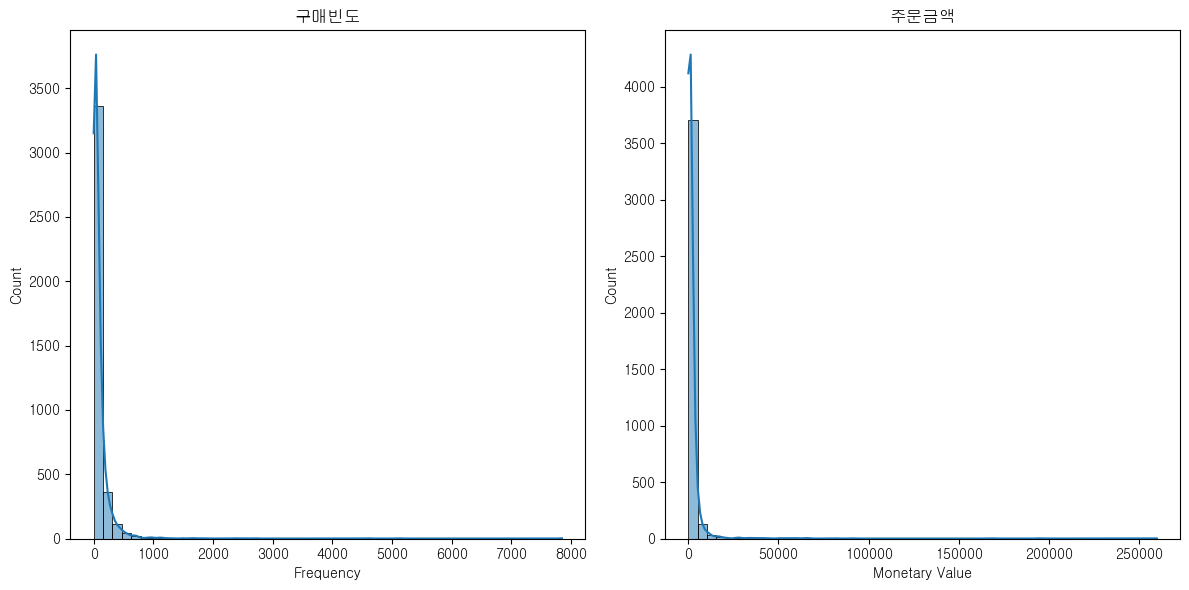

In [ ]:
# - 4. RFM 기반 고객 세그멘테이션
# 온라인 판매 데이터는 소매업체(b2b거래)로 추정되는 특정 고객의 대규모 주문이 포함되어 있어 주문 횟수와 주문 금액에서 개인 고객 주문과 매우 큰 차이가 있음을 왜곡된 
# 데이터 분포도를 시각화하여 확인

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Gulim'

# 데이터셋 df2의 주문 횟수(Frequency)와 주문 금액(주문금액)의 분포 시각화
plt.figure(figsize=(12, 6))

# 주문 횟수(Frequency) 분포
plt.subplot(1, 2, 1)
sns.histplot(df2['Frequency'], bins=50, kde=True)
plt.title('구매빈도')
plt.xlabel('Frequency')
plt.ylabel('Count')

# 주문 금액(주문금액) 분포
plt.subplot(1, 2, 2)
sns.histplot(df2['주문금액'], bins=50, kde=True)
plt.title('주문금액')
plt.xlabel('Monetary Value')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

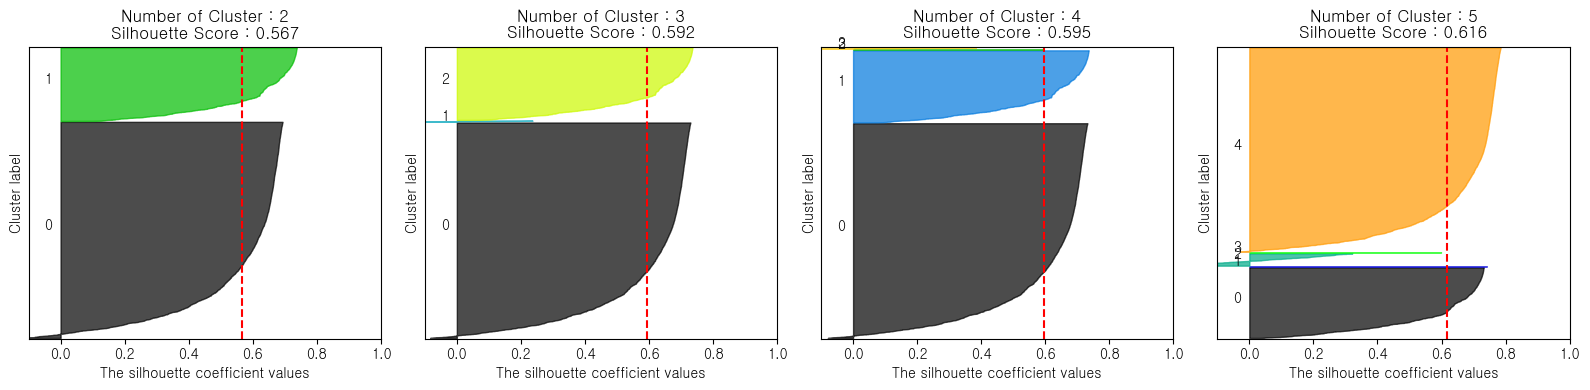

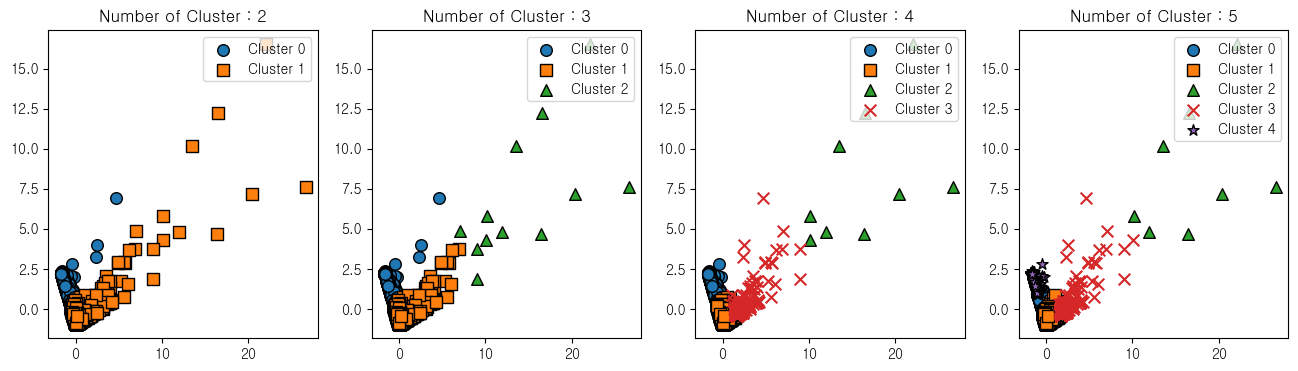

In [ ]:
# * 왜곡 정도가 매우 높은 데이터 세트에 K-평균을 적용하면 중심의 개수를 증가시키더라도 변별력이 떨어지는 군집화가 수행되기
#  때문에 StandScaler로 평균과 표준편차를 재조정한 후 시각화하여 군집화 결과를 확인. 시각화는 제공된 사용자 함수 이용하며 군집 개수를 2 ~ 5개 변화시키면서 수행

#   - 제공된 코드로 아래 작업 수행
#   - visualize_silhouette(cluster_lists, X_features)
#   - visualize_kmeans_plot_multi(cluster_lists, X_features)   


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


def visualize_silhouette(cluster_lists, X_features):

        n_cols = len(cluster_lists)

        # subplots 생성
        fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
        if n_cols == 1:
            axs = [axs]

        for ind, n_cluster in enumerate(cluster_lists):
            # KMeans 클러스터링 수행 및 실루엣 스코어 계산
            clusterer = KMeans(n_clusters=n_cluster, max_iter=500, random_state=0)
            cluster_labels = clusterer.fit_predict(X_features)

            sil_avg = silhouette_score(X_features, cluster_labels)
            sil_values = silhouette_samples(X_features, cluster_labels)

            y_lower = 10
            axs[ind].set_title('Number of Cluster : {}\nSilhouette Score : {:.3f}'.format(n_cluster, sil_avg))
            axs[ind].set_xlabel("The silhouette coefficient values")
            axs[ind].set_ylabel("Cluster label")
            axs[ind].set_xlim([-0.1, 1])
            axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
            axs[ind].set_yticks([])
            axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

            # 클러스터링 갯수별로 실루엣 스코어 시각화
            for i in range(n_cluster):
                ith_cluster_sil_values = sil_values[cluster_labels == i]
                ith_cluster_sil_values.sort()

                size_cluster_i = ith_cluster_sil_values.shape[0]
                y_upper = y_lower + size_cluster_i

                color = cm.nipy_spectral(float(i) / n_cluster)
                axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values,
                                    facecolor=color, edgecolor=color, alpha=0.7)
                axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
                y_lower = y_upper + 10

            axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

        plt.tight_layout()
        plt.show()



### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화
def visualize_kmeans_plot_multi(cluster_lists, X_features):

        # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성
        n_cols = len(cluster_lists)
        fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

        # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
        pca = PCA(n_components=2)
        pca_transformed = pca.fit_transform(X_features)
        dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])

        # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
        for ind, n_cluster in enumerate(cluster_lists):

            # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장.
            clusterer = KMeans(n_clusters = n_cluster, n_init='auto', max_iter=500, random_state=0)
            cluster_labels = clusterer.fit_predict(pca_transformed)
            dataframe['cluster']=cluster_labels

            unique_labels = np.unique(clusterer.labels_)
            markers=['o', 's', '^', 'x', '*']

            # 클러스터링 결과값 별로 scatter plot 으로 시각화
            for label in unique_labels:
                label_df = dataframe[dataframe['cluster']==label]
                if label == -1:
                    cluster_legend = 'Noise'
                else :
                    cluster_legend = 'Cluster '+str(label)
                axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70, edgecolor='k', marker=markers[label], label=cluster_legend)
                # axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70, marker='o', edgecolor='k', facecolor='none')

            axs[ind].set_title('Number of Cluster : '+ str(n_cluster))
            axs[ind].legend(loc='upper right')

        plt.show()


# 데이터 스케일링 및 시각화 함수 호출
scaler = StandardScaler()
df2_scaled = scaler.fit_transform(df2[['Recency', 'Frequency', '주문금액']])

# 시각화에 사용할 클러스터링 갯수 리스트
cluster_lists = [2, 3, 4, 5]

# 실루엣 스코어 시각화 함수 실행
visualize_silhouette(cluster_lists, df2_scaled)

# KMeans 클러스터링 결과 시각화 함수 실행
visualize_kmeans_plot_multi(cluster_lists, df2_scaled)


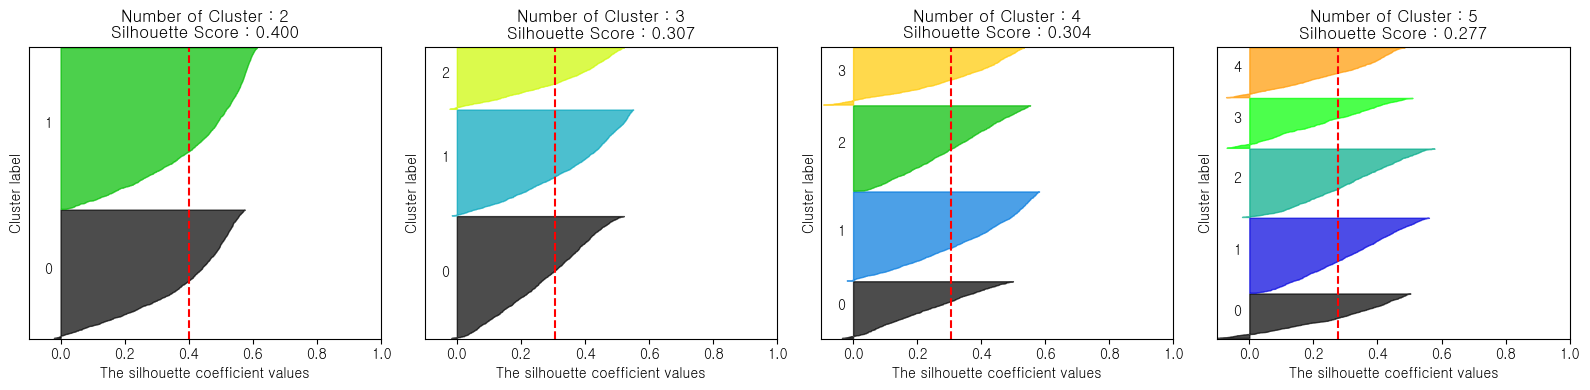

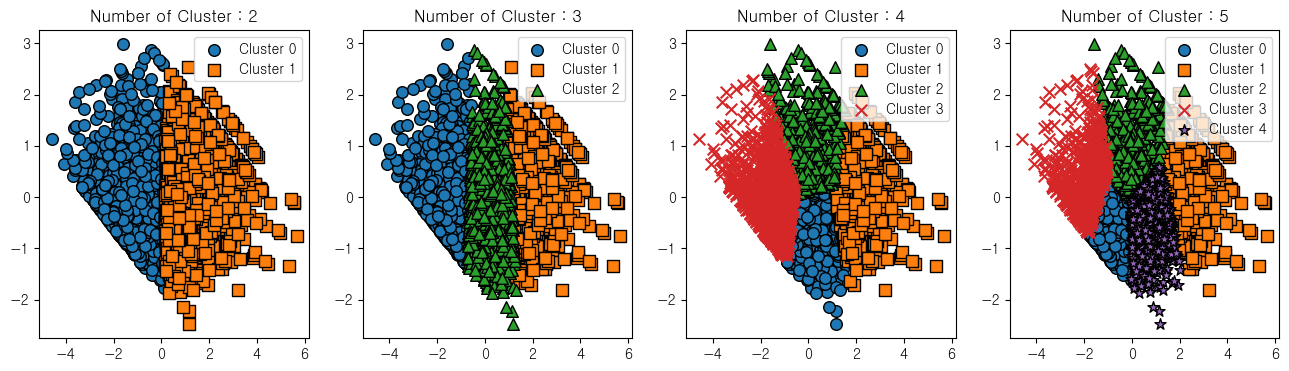

,Recency_mean,Recency_std,Frequency_mean,Frequency_std,주문금액_mean,주문금액_std
Cluster,,,,,,
0,3.742845,0.983602,4.001789,0.674484,6.730820,0.704829
1,4.828228,0.920986,2.525077,0.786669,5.435483,0.726550
2,2.135525,1.009848,5.225734,0.790410,8.093384,0.895735


In [ ]:
#5.  
#데이터 세트의 왜곡정도를 낮추기 위해 로그변환 이용하여 다시 시각화하여 군집화 결과를 확인    
#3개 군집의 특징을 통계적 방법을 통해서 해석 및 활용 방안 수립

import numpy as np

# 데이터 세트에 로그 변환 적용
df2_log_transformed = np.log1p(df2[['Recency', 'Frequency', '주문금액']])

# 스케일링 적용
scaler = StandardScaler()
df2_log_scaled = scaler.fit_transform(df2_log_transformed)

# 로그 변환된 데이터에 대해 실루엣 스코어 시각화
visualize_silhouette(cluster_lists, df2_log_scaled)

# 로그 변환된 데이터에 대해 KMeans 클러스터링 결과 시각화
visualize_kmeans_plot_multi(cluster_lists, df2_log_scaled)

# KMeans 클러스터링 적용 (군집 수 3으로 설정)
kmeans = KMeans(n_clusters=3, random_state=0)
df2_log_transformed['Cluster'] = kmeans.fit_predict(df2_log_scaled)

# 3개 군집의 특징 통계
cluster_summary = df2_log_transformed.groupby('Cluster').agg(['mean', 'std'])
cluster_summary.columns = ['_'.join(column) for column in cluster_summary.columns]

cluster_summary

1. **클러스터 0** (우수 고객)
   - **Recency (최근성)**: 상대적으로 recency가 중간 정도인 그룹 (평균 3.74). 이 클러스터의 고객들은 비교적 최근에 구매한 것으로 볼 수 있음
   - **Frequency (빈도)**: 중간 정도의 구매 빈도 (평균 4.00). 이 클러스터의 고객들은 꾸준히 구매하는 경향이 있음
   - **Monetary (금액)**: 높은 구매 금액 (평균 6.73). 이 고객들은 군집들 중 두번째로 높은 구매 금액 집단이라 할 수 있음
 
2. **클러스터 1** (그냥 고객)
   - **Recency**: 가장 높은 recency를 가진 그룹 (평균 4.83). 이 클러스터의 고객들은 상대적으로 가장 오랜 시간 동안 구매하지 않았음
   - **Frequency**: 낮은 구매 빈도 (평균 2.52). 이 클러스터의 고객들은 드물게 구매하는 경향이 있음
   - **Monetary**: 낮은 구매 금액 (평균 5.43). 이 클러스터의 고객들은 적은 금액을 지출하는 경향이 있음

3. **클러스터 2**   (최우수 고객)
   - **Recency**: 가장 낮은 recency를 가진 그룹 (평균 2.13). 이 클러스터의 고객들은 가장 최근에 구매한 것으로 볼 수 있음
   - **Frequency**: 높은 구매 빈도 (평균 5.22). 이 클러스터의 고객들은 자주 구매하는 경향이 있음
   - **Monetary**: 가장 높은 구매 금액 (평균 8.09). 이 클러스터의 고객들은 가장 높은 구매력을 가지고 있다고 볼 수 있음

이러한 해석을 바탕으로, 각 클러스터에 대한 마케팅 전략을 개발할 수 있을 것으로 보임. 클러스터 2는 가장 최근에 활동한 고객으로, 이들에게 더 많은 구매를 유도하기 위한 프로모션 또는 충성도 프로그램을 제안하는 것이 좋을 수 있음. 클러스터 0은 비교적 최근에 구매한 꾸준한 고객으로, 이들에게 새로운 제품이나 프리미엄 제품을 제안하는 것이 좋을 수 있음. 클러스터 1은 오랜 기간 동안 구매하지 않은 고객으로, 이들을 다시 유치하기 위한 특별 프로모션을 고려할 수 있음.